In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from ctypes import *
import matplotlib.pyplot as plt
import joblib

WinDLL('G:\\CUDA\\cudnn\\cuda\\bin\\cudnn_ops_infer64_8.dll')
WinDLL('G:\\CUDA\\cudnn\\cuda\\bin\\cudnn_adv_infer64_8.dll')
WinDLL('G:\\CUDA\\cudnn\\cuda\\bin\\cudnn_adv_train64_8.dll')


<WinDLL 'G:\CUDA\cudnn\cuda\bin\cudnn_adv_train64_8.dll', handle 7ffd55890000 at 0x14533188340>

In [2]:
eeg_df = pd.read_excel('eegdata_72var.xlsx')
ques_df = pd.read_excel('questionare.xlsx')
ques_df = ques_df.loc[:,['sub','group','gender','age','外向性','宜人性','尽责性','神经质','开放性']]

In [3]:
df_initial = pd.merge(eeg_df,ques_df,on=['sub'])
#将分类变量转为0与1
df_initial.replace('male',1,inplace=True)
df_initial.replace('female',0,inplace=True)
df_initial['group'].replace(1,0,inplace=True)  #group为0的是被社会拒斥的        ##！！！！group实际上不应该出现在我的实验中，考虑删掉这个变量
df_initial['group'].replace(2,1,inplace=True)  #group为1的是未被社会拒斥的
df_initial['con'].replace('neg',0,inplace=True)
df_initial['con'].replace('pos',1,inplace=True)


df_initial.drop(columns=['sub','group'],inplace=True)
x = df_initial.drop(columns=['外向性','宜人性','尽责性','神经质','开放性'])
x = StandardScaler().fit_transform(x)
y = df_initial.loc[:,['外向性','宜人性','尽责性','神经质','开放性']]

for i in ['外向性','宜人性','尽责性','神经质','开放性']:
    y_temp = y.loc[:,[i]]
    x_train,x_test,y_train,y_test = train_test_split(x,y_temp,test_size=0.15,random_state=1)
    model = keras.models.load_model('models\\'+i+'.h5')
    y_pred = model.predict(x_test)
    y_pred.astype(np.float32)
    y_test = np.array(y_test)

    mse = sum((y_test-y_pred)**2)/(y_pred.shape[0])
    SS_R = sum((y_test-y_pred)**2)
    SS_T = sum((y_test-np.mean(y_test))**2)
    r_squared = 1 - (float(SS_R))/SS_T
    print('特质%s的均方方差是%f,R平方是%f,矫正R平方是%f'%(i,mse,r_squared))

In [4]:
x.shape

(2636, 63)

In [5]:
def train_model(x_train, y_train, x_test, y_test):
    model = keras.Sequential([
    layers.Dense(128, activation = 'relu',kernel_regularizer=keras.regularizers.l2(),input_shape=(63,1)),
    layers.Bidirectional(layers.LSTM(256, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(256, return_sequences = False)),
    layers.Dropout(0.3),
    layers.Dense(256, activation = 'relu',kernel_regularizer=keras.regularizers.l2()),
    layers.Dense(1)])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mse'],
    )
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=50,
        epochs=200,
        verbose=0,
        callbacks=[es]
    )
    return model, history

In [13]:
model_list = list()
history_list = list()
for i in ['外向性','宜人性','尽责性','神经质','开放性']:
    y_temp = y.loc[:,[i]]
    x_train,x_test,y_train,y_test = train_test_split(x,y_temp,test_size=0.15,random_state=2)
    x_train = np.array(x_train).reshape(-1,63,1)
    x_test = np.array(x_test).reshape(-1,63,1)
    model, history = train_model(x_train,y_train,x_test,y_test)
    model_list.append(model)
    history_list.append(history)
    y_pred =model.predict(x_test)
    y_test = np.array(y_test,dtype=np.int32)
    SS_R = sum((y_test-y_pred)**2)
    SS_T = sum((y_test-np.mean(y_test))**2)
    r_squared = 1 - (float(SS_R))/SS_T
    adj_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    mae = np.mean(np.abs(y_pred-y_test))
    print('特质%s的R方值为%f, 矫正R方值为%f, mae值为%f'%(i,r_squared,adj_r_squared,mae))



Epoch 00105: early stopping
特质外向性的R方值为0.799430, 矫正R方值为0.761370, mae值为1.876073
Epoch 00058: early stopping
特质宜人性的R方值为0.273893, 矫正R方值为0.136108, mae值为3.226771
Epoch 00089: early stopping
特质尽责性的R方值为0.580552, 矫正R方值为0.500958, mae值为2.846551
Epoch 00050: early stopping
特质神经质的R方值为0.703532, 矫正R方值为0.647275, mae值为2.826889
Epoch 00102: early stopping
特质开放性的R方值为0.897442, 矫正R方值为0.877981, mae值为1.553835


y_pred =model.predict(x_test)
y_test = np.array(y_test,dtype=np.int32)
SS_R = sum((y_test-y_pred)**2)
SS_T = sum((y_test-np.mean(y_test))**2)
r_squared = 1 - (float(SS_R))/SS_T
adj_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
print('特质%s的R方值为%f'%(i,r_squared))

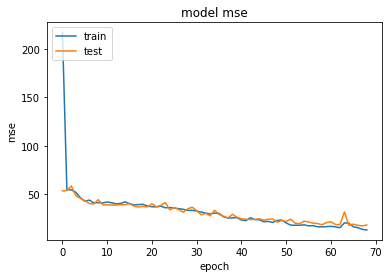

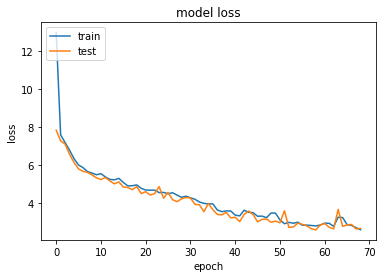

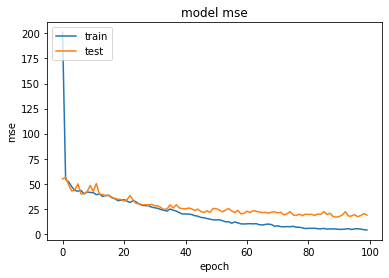

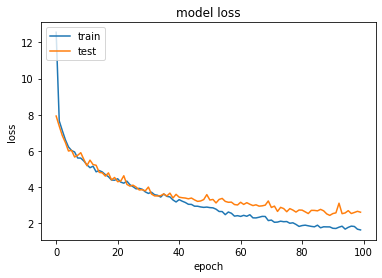

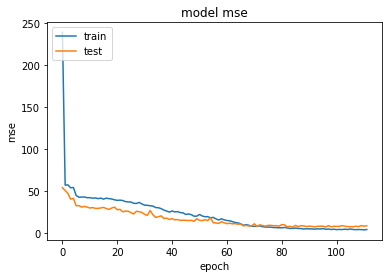

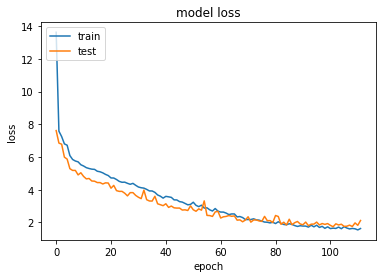

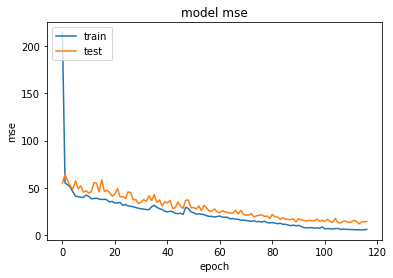

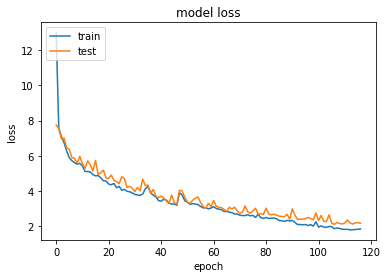

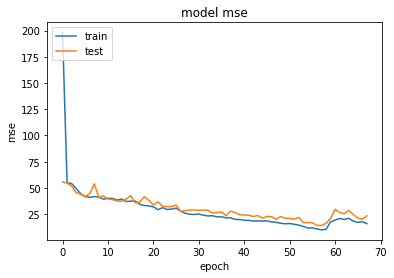

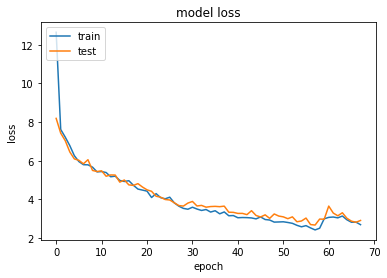

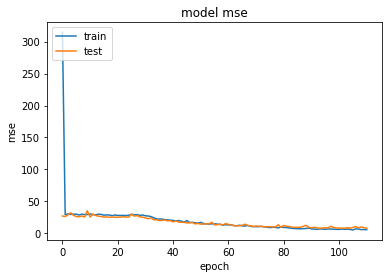

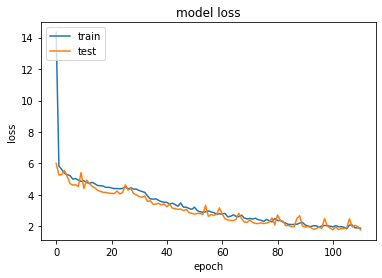

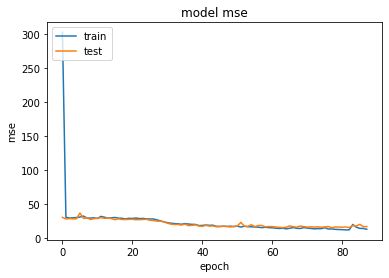

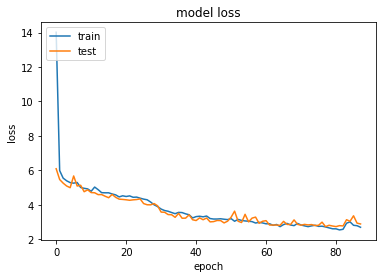

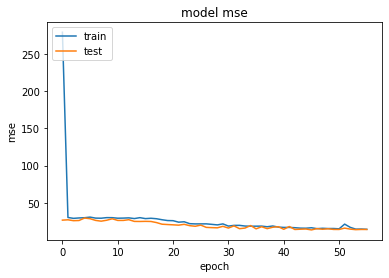

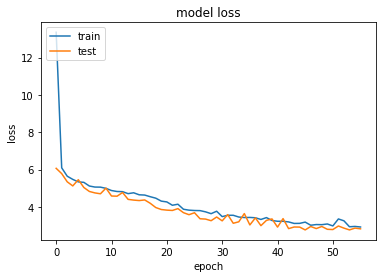

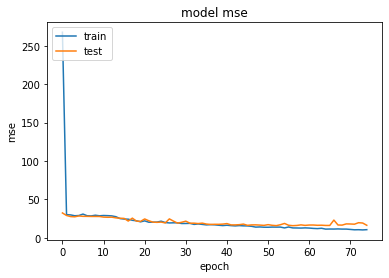

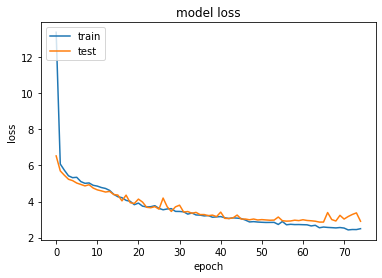

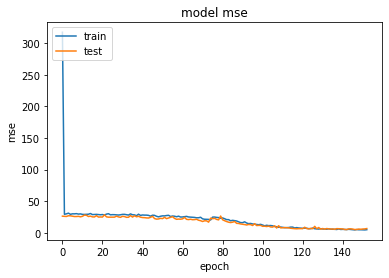

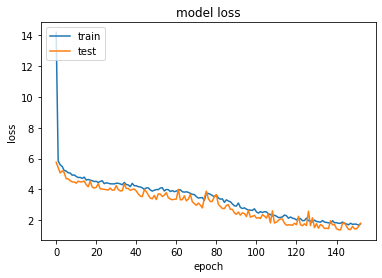

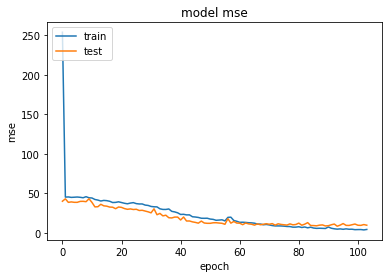

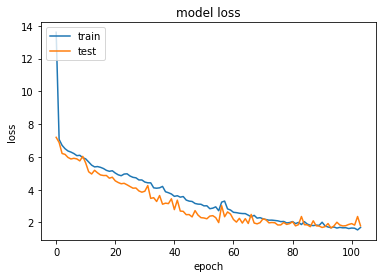

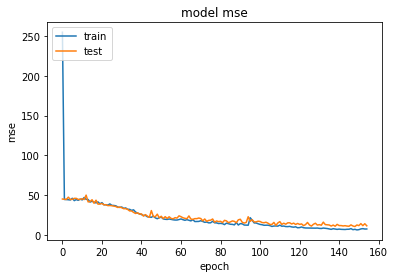

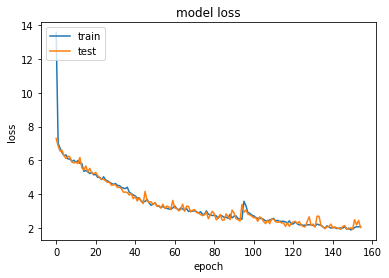

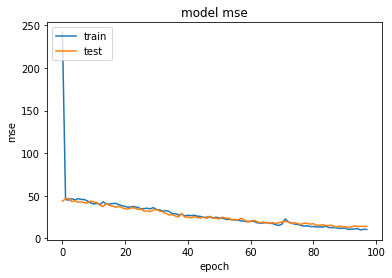

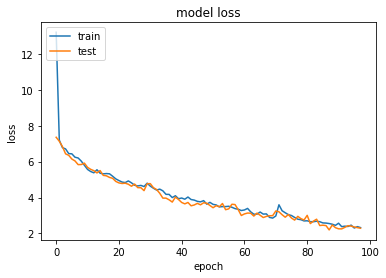

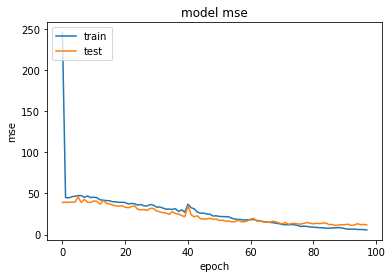

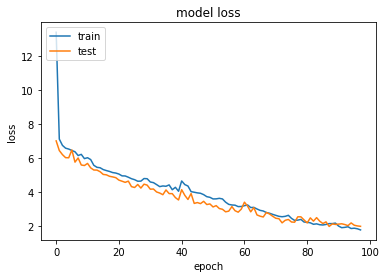

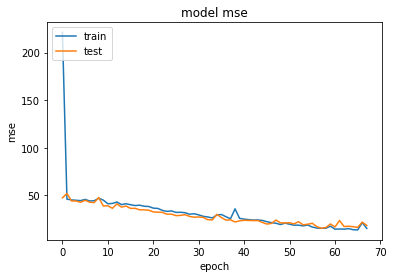

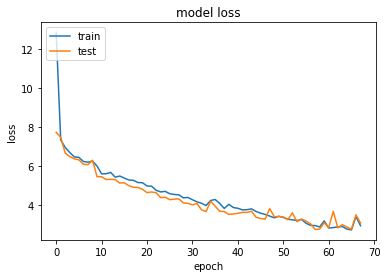

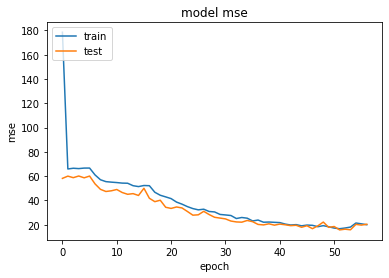

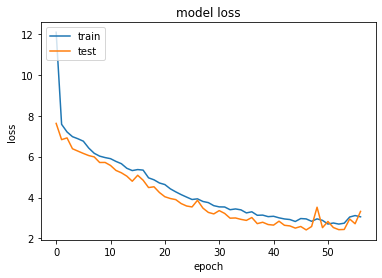

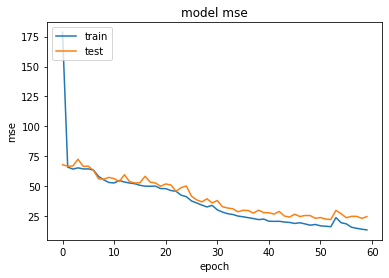

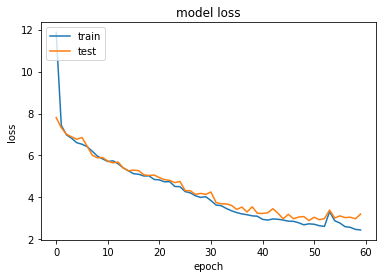

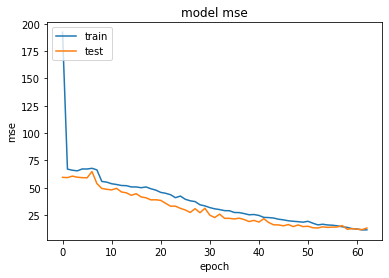

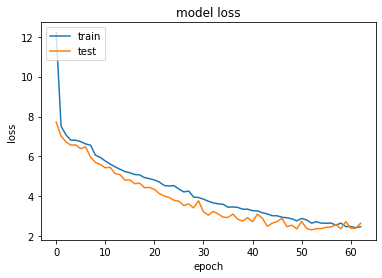

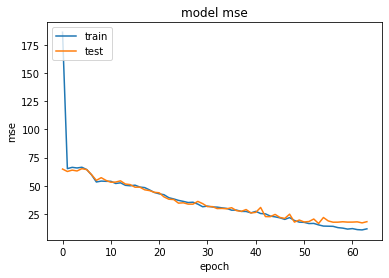

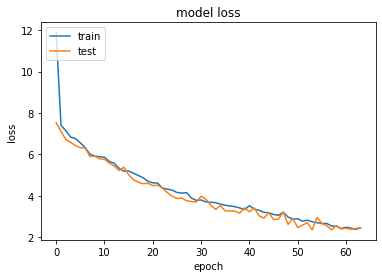

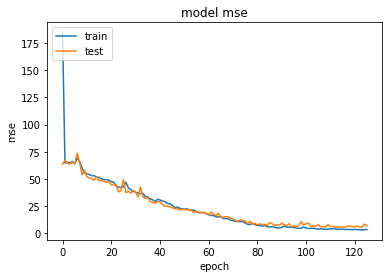

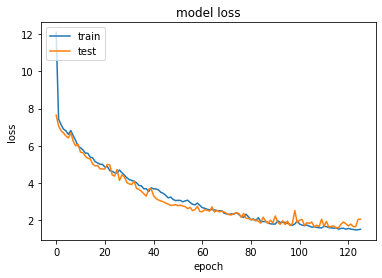

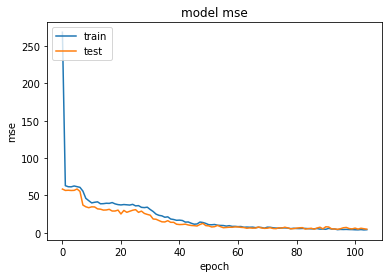

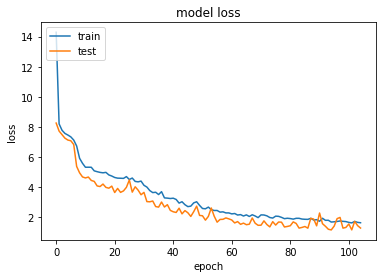

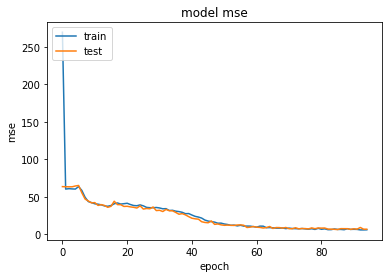

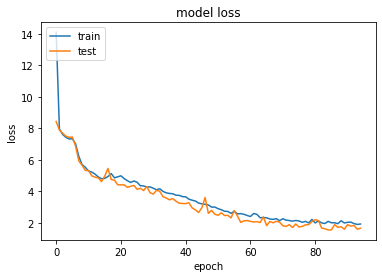

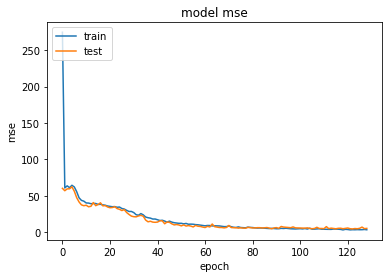

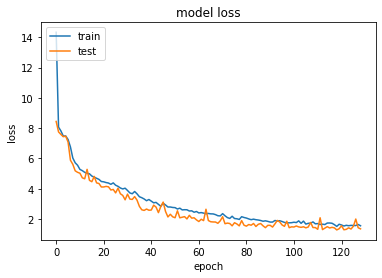

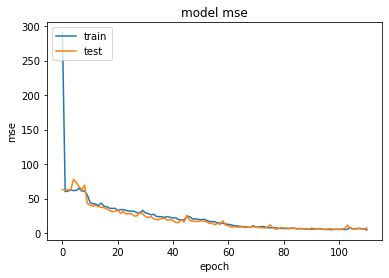

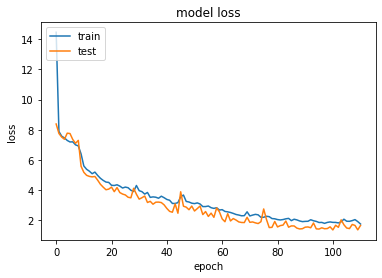

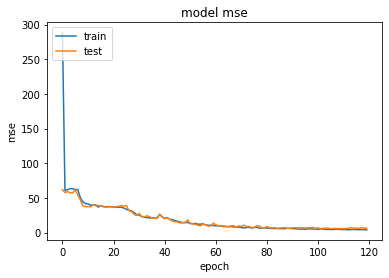

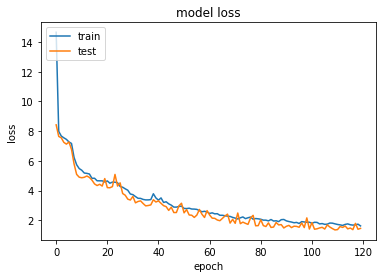

In [11]:
for history in history_list:
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()